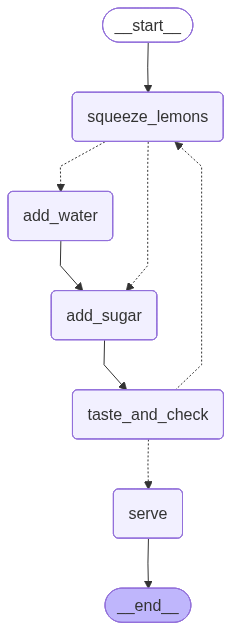

In [1]:
from langgraph.graph import StateGraph
from typing import TypedDict, Dict, Any

# Define the updated state with skip flag and attempt count
class LemonSkipState(TypedDict):
    lemons: int
    sugar: int
    water: str
    juice: str
    mix: str
    final: str
    sweet: bool
    attempts: int
    skip_water: bool  # controls skipping

# Nodes
def squeeze_lemons(state: Dict[str, Any]) -> Dict[str, Any]:
    state["juice"] = f"Juice from {state['lemons']} lemons"
    return state

def add_water(state: Dict[str, Any]) -> Dict[str, Any]:
    state["mix"] = f"{state['juice']} + {state['water']} water"
    return state

def add_sugar(state: Dict[str, Any]) -> Dict[str, Any]:
    state["sugar"] += 1
    state["attempts"] += 1
    state["mix"] = f"{state['juice']} + {state['water']} water + {state['sugar']} spoons sugar"
    return state

def taste_and_check(state: Dict[str, Any]) -> Dict[str, Any]:
    # Consider sweet if sugar >= 2
    state["sweet"] = state["sugar"] >= 2
    # After first loop, skip water
    if state["attempts"] >= 1:
        state["skip_water"] = True
    return state

def serve(state: Dict[str, Any]) -> Dict[str, Any]:
    state["final"] = f"{state['mix']} → Served!"
    return state

# Decision function to skip water
def route_after_squeeze(state: Dict[str, Any]) -> str:
    return "add_sugar" if state.get("skip_water", False) else "add_water"

# Looping condition
def check_sweetness(state: Dict[str, Any]) -> str:
    return "serve" if state["sweet"] else "squeeze_lemons"

# Build graph
builder = StateGraph(LemonSkipState)
builder.add_node("squeeze_lemons", squeeze_lemons)
builder.add_node("add_water", add_water)
builder.add_node("add_sugar", add_sugar)
builder.add_node("taste_and_check", taste_and_check)
builder.add_node("serve", serve)

builder.set_entry_point("squeeze_lemons")

# After squeezing, route based on skip_water
builder.add_conditional_edges("squeeze_lemons", route_after_squeeze, {
    "add_water": "add_water",
    "add_sugar": "add_sugar"
})

builder.add_edge("add_water", "add_sugar")
builder.add_edge("add_sugar", "taste_and_check")

builder.add_conditional_edges("taste_and_check", check_sweetness, {
    "serve": "serve",
    "squeeze_lemons": "squeeze_lemons"
})

builder.set_finish_point("serve")

# Compile and run
#graph = builder.compile()

from IPython.display import Image, display
graph = builder.compile()
# Visualize
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

initial_state = {
    "lemons": 4,
    "sugar": 0,
    "water": "1 glass",
    "juice": "",
    "mix": "",
    "final": "",
    "sweet": False,
    "attempts": 0,
    "skip_water": False
}

result = graph.invoke(initial_state)

